# 1. Описание проекта

Представьте, что вы работаете датасаентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов нахождения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель играет нечестно, и его стоит проверить.

Описание датасета и исходных данных

* Файлы для соревнования
* hotels_train.csv - набор данных для обучения
* hotels_test.csv - набор данных для оценки качества
* submission.csv - файл сабмишна в нужном формате
* Признаки
* hotel_address - адрес отеля
* review_date - дата, когда рецензент разместил соответствующий отзыв.
* average_score - средний балл отеля, рассчитанный на основе последнего комментария за последний год
* hotel_name - название отеля
* reviewer_nationality - национальность рецензента
* negative_review - отрицательный отзыв, который рецензент дал отелю.
* review_total_negative_word_counts - общее количество слов в отрицательном отзыв
* positive_review - положительный отзыв, который рецензент дал отелю
* review_total_positive_word_counts - общее количество слов в положительном отзыве
* reviewer_score - оценка, которую рецензент поставил отелю на основе своего опыта
* total_number_of_reviews_reviewer_has_given - количество отзывов, которые рецензенты дали в прошлом
* total_number_of_reviews - общее количество действительных отзывов об отеле
* tags - теги, которые рецензент дал отелю.
* days_since_review - продолжительность между датой проверки и датой очистки
* additional_number_of_scoring - есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat - широта отеля
* lng - долгота отеля

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import nltk
import pandas as pd
import plotly.express as px
import seaborn as sns
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from haversine import haversine
from datetime import datetime
from sklearn import metrics
from sklearn import preprocessing
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
#!pip freeze > requirements.txt

In [4]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [5]:
#Посмотрим на структуру и тип данных
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [8]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [9]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

Столбцы с пропусками: lat и lng

In [13]:
#пока не решено, что с ним делать заполним нулями, хотя для координат это плохая идея (в дальнейшем удалил эти столбцы)
data['lat'] = data['lat'].fillna(0, inplace=True)
data['lng'] = data['lng'].fillna(0, inplace=True)

# 2. Исследование и проектирование признаков 

Для начала проанализируем сами отзывы и тех, кто их ставил.

In [14]:
data['reviewer_nationality'].nunique() #посмотрим сколько уникальных стран посещали отели

227

In [15]:

#Закодируем признак reviewer_nationality (так как уникальных значений много, воспользуемся бинарным кодированием)

bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)
data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,sample,reviewer_score,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,0,0.0,0,0,0,0,0,0,0,1
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,0,0.0,0,0,0,0,0,0,1,0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,...,0,0.0,0,0,0,0,0,0,1,1


In [16]:
#Удалим признак reviewer_nationality
data.drop(['reviewer_nationality'],axis=1,inplace=True)

Проанализируем отзывы посетителей.

In [17]:
data['negative_review'].value_counts().head(30)

No Negative            127890
 Nothing                14295
 Nothing                 4236
 nothing                 2225
 N A                     1037
 None                     984
                          849
 N a                      509
 Breakfast                407
 Small room               373
 Location                 368
 Everything               326
 All good                 318
 Nothing really           316
 none                     302
 nothing                  283
 No complaints            274
 Price                    260
 Nothing really           254
 Nil                      247
 n a                      227
 Nothing at all           221
 Nothing to dislike       209
 Nothing at all           194
 Small rooms              188
 None                     182
 No complaints            176
 All good                 152
 NA                       148
 Expensive                142
Name: negative_review, dtype: int64

Как видим в отрицательных отзывах есть информация, что отрицательного ничего не было. Так же проверим позитивные отзывы.

In [18]:
data['positive_review'].value_counts().head(30)

No Positive            35946
 Location               9222
 Everything             2284
 location               1677
 Nothing                1243
 The location           1126
 Great location         1047
 Good location           927
 Location                915
 Everything              613
 Breakfast               608
 Friendly staff          515
 Staff                   453
 Excellent location      392
 Great location          372
 Location and staff      333
 everything              319
 Good location           276
 Nothing                 225
 Comfy bed               222
 nothing                 217
 The location            215
 good location           206
 The staff               197
 Good breakfast          189
                         183
 Location staff          180
 the location            180
 Location was good       178
 Location was great      178
Name: positive_review, dtype: int64

Аналогичная картина. Заменим противоположные отзывы на реальные.

In [19]:
def reverse_opinion_negative (arg):
    neg_list=['no negative','nothing','n a','na','none','all good','no complaints',
              'nothing really','nothing at all ','nothing to dislike','absolutely nothing',
             'everything was great','no','i liked everything','nothing to complain about',
             'everything was good','liked everything','nothing all good','everything was perfect','everything was fine','all was good',
             'nothing it was perfect','non','no complaints at all','nothing comes to mind',
            'no complaints at all','nothing everything was perfect','we liked everything','no negatives',
             'nothing in particular','there was nothing to dislike','nothing everything was great',
             'nothing to report','it was all good','there was nothing we didn t like','loved everything',
             'no thing']
    arg=' '.join(arg.split())
    if arg.lower() in neg_list:
        return 'All Good'
    else:
        return arg

In [20]:
data['negative_review']=data['negative_review'].apply(reverse_opinion_negative)
data['negative_review'].value_counts().head(30)


All Good                   158279
                              849
Small room                    455
Breakfast                     449
Location                      421
Nothing at all                415
Everything                    367
Price                         301
Nil                           269
Small rooms                   245
Can t think of anything       234
Leaving                       220
Expensive                     181
Nothing not to like           175
Room size                     156
Having to leave               154
Very small room               153
Staff                         143
Not much                      137
See above                     136
Room was very small           116
The price                     114
Expensive breakfast           114
small room                    104
Room too small                103
Pillows                       100
Not applicable                 98
breakfast                      94
Parking                        92
Room very smal

In [21]:
def reverse_opinion_positiv (arg):
    neg_list=['no positive','nothing']
    arg=' '.join(arg.split())
    if arg.lower() in neg_list:
        return 'All Bad'
    else:
        return arg

In [22]:
data['positive_review']=data['positive_review'].apply(reverse_opinion_positiv)
data['positive_review'].value_counts().head(30)

All Bad                       37677
Location                      10137
Everything                     2897
location                       1736
Great location                 1419
The location                   1341
Good location                  1203
Breakfast                       664
Friendly staff                  603
Excellent location              547
Staff                           486
Location and staff              371
everything                      371
Location was great              294
Location was good               277
Everything was perfect          276
Comfy bed                       263
Good breakfast                  248
Location is great               236
The staff                       234
Perfect location                227
good location                   225
Location location location      218
Location staff                  215
Location is good                214
Breakfast was good              198
the location                    195
Very friendly staff         

In [23]:
# создаем два  анализатора для положительных и отрицательных отзывов:
analiz_neg = SentimentIntensityAnalyzer()
analiz_pos = SentimentIntensityAnalyzer()

data['negative_points'] = data['negative_review'].apply(lambda x: analiz_neg.polarity_scores(x))
data['positive_points'] = data['positive_review'].apply(lambda x: analiz_neg.polarity_scores(x))

In [24]:
data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7,negative_points,positive_points
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,Would have appreciated a shop in the hotel tha...,52,16670,Hotel was great clean friendly staff free brea...,62,...,0,0,0,0,0,0,0,1,"{'neg': 0.129, 'neu': 0.747, 'pos': 0.125, 'co...","{'neg': 0.0, 'neu': 0.671, 'pos': 0.329, 'comp..."
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,No tissue paper box was present at the room,10,5018,All Bad,0,...,0,0,0,0,0,0,1,0,"{'neg': 0.216, 'neu': 0.784, 'pos': 0.0, 'comp...","{'neg': 0.778, 'neu': 0.222, 'pos': 0.0, 'comp..."
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Pillows,3,351,Nice welcoming and service,5,...,0,0,0,0,0,0,1,1,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.26, 'pos': 0.74, 'compou..."


In [25]:
#Не буду заниматься самодеятельностью и придумывать свои оценки на основе трех значений от SentimentIntensityAnalyzer,
#просто возьму итоговую оценку(compound), пределы которой -1 +1
data['neg_compound_score']=data['negative_points'].apply(lambda x: x['compound'])
data['pos_compound_score']=data['positive_points'].apply(lambda x: x['compound'])

In [26]:
data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7,negative_points,positive_points,neg_compound_score,pos_compound_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,Would have appreciated a shop in the hotel tha...,52,16670,Hotel was great clean friendly staff free brea...,62,...,0,0,0,0,0,1,"{'neg': 0.129, 'neu': 0.747, 'pos': 0.125, 'co...","{'neg': 0.0, 'neu': 0.671, 'pos': 0.329, 'comp...",-0.0554,0.9615
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,No tissue paper box was present at the room,10,5018,All Bad,0,...,0,0,0,0,1,0,"{'neg': 0.216, 'neu': 0.784, 'pos': 0.0, 'comp...","{'neg': 0.778, 'neu': 0.222, 'pos': 0.0, 'comp...",-0.2960,-0.5423
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Pillows,3,351,Nice welcoming and service,5,...,0,0,0,0,1,1,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.26, 'pos': 0.74, 'compou...",0.0000,0.6908


In [27]:
#Итоговая оценка на основе отзывов
data['summary_compound_score']=data['neg_compound_score']+data['pos_compound_score']

<AxesSubplot:>

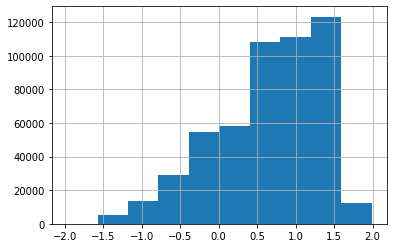

In [28]:
#посмотрим ее распределение
data['summary_compound_score'].hist()

<AxesSubplot:>

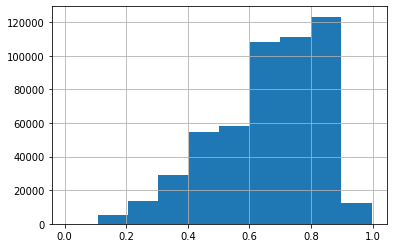

In [29]:
#приведем ее к виду от 0 до 1 (где 0 плохо, 1 идеально)
data['summary_compound_score']=(data['summary_compound_score']+2)/4
data['summary_compound_score'].hist()

Проанализируем расположение отелей по странам и городам.

In [30]:
data['hotel_country'] = data['hotel_address'].apply(lambda x: x.split()[-1])
data['hotel_country'].value_counts()

Kingdom        262301
Spain           60149
France          59928
Netherlands     57214
Austria         38939
Italy           37207
Name: hotel_country, dtype: int64

Как видим в датасете представлено всего 6 стран, преобразим Kingdom в United Kingdom.

In [31]:
data.loc[data['hotel_country'] == 'Kingdom','hotel_country'] = 'United Kingdom'
data['hotel_country'].value_counts()

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: hotel_country, dtype: int64

In [32]:
#Теперь создадим признак для города, мы знаем что после названия страны в адресе идет название города.(для United Kingdom сделаем поправку)
data['hotel_city'] = data['hotel_address'].apply(lambda x: x.split()[-5] if x.split()[-1] == 'Kingdom' else x.split()[-2])
data['hotel_city'].value_counts()

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: hotel_city, dtype: int64

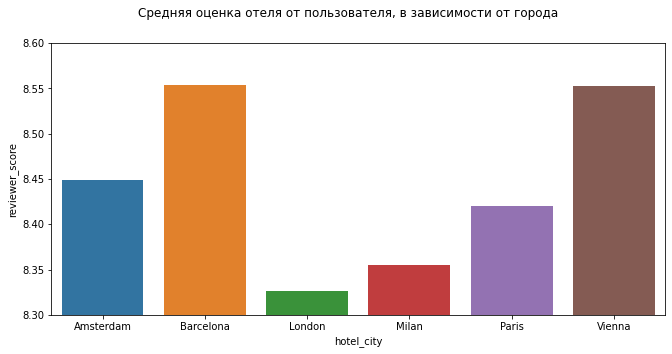

In [33]:
#Построим среднюю оценку по городам на основе показателя reviewer_score
reviewer_score_city = data[data['sample']==1].pivot_table(
    values='reviewer_score', 
    index='hotel_city', 
    aggfunc='mean')

plt.figure(figsize=(11, 5))
barplot_m = sns.barplot(
    data = reviewer_score_city,
    x = reviewer_score_city.index, 
    y = 'reviewer_score')
plt.suptitle('Средняя оценка отеля от пользователя, в зависимости от города')

plt.ylim(8.3, 8.6);

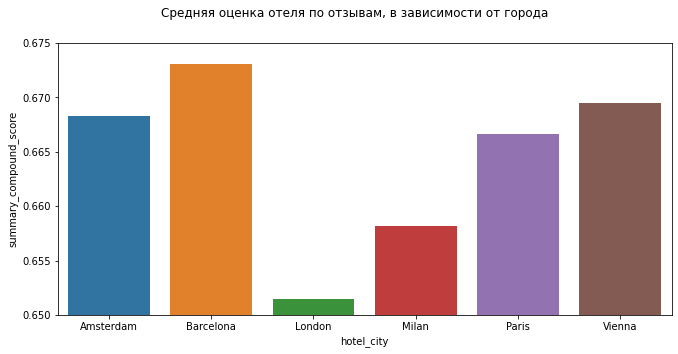

In [34]:
#интересно посмотреть оценку основанную на отзывах
reviewer_score_city = data[data['sample']==1].pivot_table(
    values='summary_compound_score', 
    index='hotel_city', 
    aggfunc='mean')

plt.figure(figsize=(11, 5))
barplot_m = sns.barplot(
    data = reviewer_score_city,
    x = reviewer_score_city.index, 
    y = 'summary_compound_score')
plt.suptitle('Средняя оценка отеля по отзывам, в зависимости от города')

plt.ylim(.65, .675);

Все отели расположены в 6 странах, причем  одна страна - один город. Признак отель_страна можно будет удалить.

In [35]:
#Закодируем признак hotel_city 
encoder = ce.OneHotEncoder(cols=['hotel_city'])
type_bin = encoder.fit_transform(data['hotel_city'])
data = pd.concat([data, type_bin], axis=1)

In [36]:
data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,pos_compound_score,summary_compound_score,hotel_country,hotel_city,hotel_city_1,hotel_city_2,hotel_city_3,hotel_city_4,hotel_city_5,hotel_city_6
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,Would have appreciated a shop in the hotel tha...,52,16670,Hotel was great clean friendly staff free brea...,62,...,0.9615,0.726525,Italy,Milan,1,0,0,0,0,0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,No tissue paper box was present at the room,10,5018,All Bad,0,...,-0.5423,0.290425,Netherlands,Amsterdam,0,1,0,0,0,0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Pillows,3,351,Nice welcoming and service,5,...,0.6908,0.672700,Spain,Barcelona,0,0,1,0,0,0


Проаназируем столбец с датой.

Известно, что отели работают совсем по разному в высокий сезон и низкий. Проверим это на практике.

In [37]:
# преобразуем данные в столбце в формат даты/времени:
data['review_date'] = pd.to_datetime(data['review_date'])

# формируем новый признак review_month:
data['review_month'] = data['review_date'].dt.month

In [38]:
data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,summary_compound_score,hotel_country,hotel_city,hotel_city_1,hotel_city_2,hotel_city_3,hotel_city_4,hotel_city_5,hotel_city_6,review_month
0,Via Senigallia 6 20161 Milan Italy,904,2017-07-21,8.1,Hotel Da Vinci,Would have appreciated a shop in the hotel tha...,52,16670,Hotel was great clean friendly staff free brea...,62,...,0.726525,Italy,Milan,1,0,0,0,0,0,7
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,2016-12-12,8.6,Urban Lodge Hotel,No tissue paper box was present at the room,10,5018,All Bad,0,...,0.290425,Netherlands,Amsterdam,0,1,0,0,0,0,12
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,2015-11-26,8.3,Alexandra Barcelona A DoubleTree by Hilton,Pillows,3,351,Nice welcoming and service,5,...,0.672700,Spain,Barcelona,0,0,1,0,0,0,11


После преобразования получилось, что по данному признаку значение декабря имеет численное значение 12, а январь 1, что дает нам право говорить, что декабрь в 12 раз больше (круче и тд.) чем январь по признаку review_date. Поэтому закодирую review_date с помощью OneHotEncoder

In [39]:
#Закодируем признак review_month 
encoder = ce.OneHotEncoder(cols=['review_month'])
type_bin = encoder.fit_transform(data['review_month'])
data = pd.concat([data, type_bin], axis=1)

In [40]:
data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,review_month_3,review_month_4,review_month_5,review_month_6,review_month_7,review_month_8,review_month_9,review_month_10,review_month_11,review_month_12
0,Via Senigallia 6 20161 Milan Italy,904,2017-07-21,8.1,Hotel Da Vinci,Would have appreciated a shop in the hotel tha...,52,16670,Hotel was great clean friendly staff free brea...,62,...,0,0,0,0,0,0,0,0,0,0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,2016-12-12,8.6,Urban Lodge Hotel,No tissue paper box was present at the room,10,5018,All Bad,0,...,0,0,0,0,0,0,0,0,0,0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,2015-11-26,8.3,Alexandra Barcelona A DoubleTree by Hilton,Pillows,3,351,Nice welcoming and service,5,...,1,0,0,0,0,0,0,0,0,0


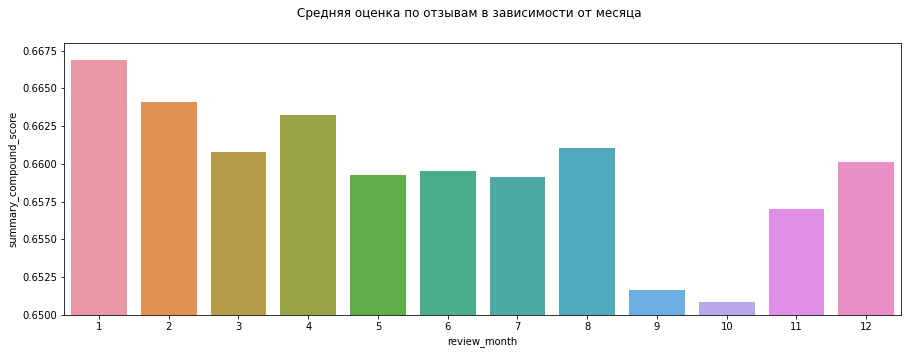

In [41]:
mask = data['sample'] == 1
pivot_month = data[mask][['review_month', 'summary_compound_score']].groupby(
    'review_month').mean()
fig5, ax5 = plt.subplots(figsize=(15, 5))
plt.suptitle('Средняя оценка по отзывам в зависимости от месяца')
bar_month = sns.barplot(
    x=pivot_month.index, 
    y=pivot_month['summary_compound_score'])

plt.ylim(.65, .668);

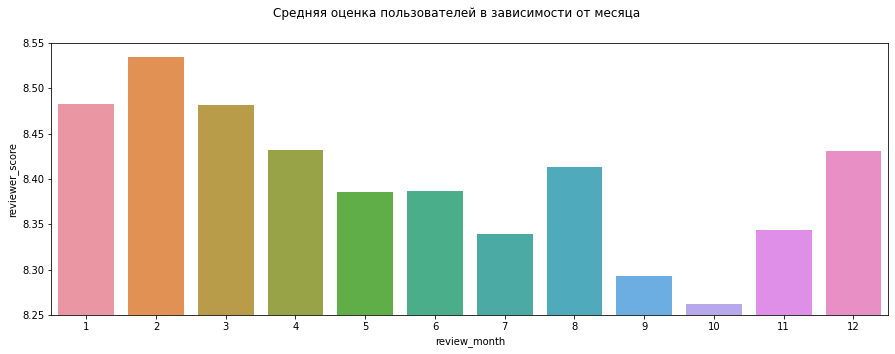

In [42]:
mask = data['sample'] == 1
pivot_month = data[mask][['review_month', 'reviewer_score']].groupby(
    'review_month').mean()
fig5, ax5 = plt.subplots(figsize=(15, 5))
plt.suptitle('Средняя оценка пользователей в зависимости от месяца')
bar_month = sns.barplot(
    x=pivot_month.index, 
    y=pivot_month['reviewer_score'])

plt.ylim(8.25, 8.55);

Посмотрим зависимость средней оценки по отзывам в зависимости от месяца и города

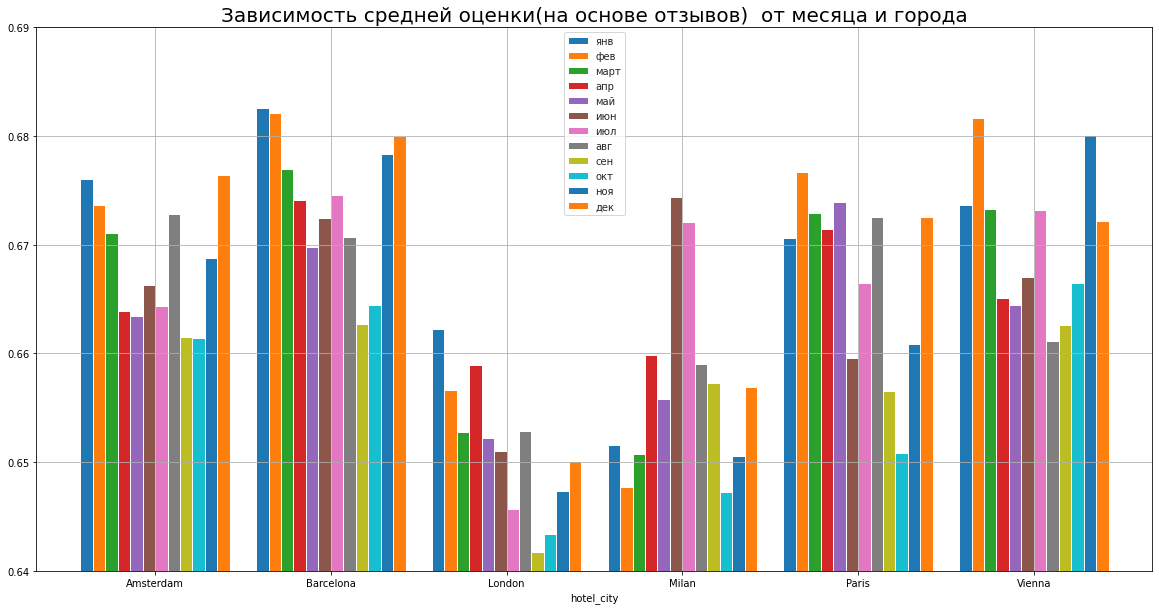

In [43]:

pivot_district_type = data[data['sample'] == 1].groupby(
    ['hotel_city', 'review_month'])['summary_compound_score'].mean().unstack()


fig1, ax1 = plt.subplots(figsize=(20, 10))
sns.set_style('whitegrid')
district_type_plot = pivot_district_type.plot(
    ax=ax1, 
    kind='bar', 
    width=0.85, 
    rot=0)
ax1.set_title('Зависимость средней оценки(на основе отзывов)  от месяца и города',size = 20)
ax1.legend(['янв', 'фев', 'март', 'апр', 'май', 'июн', 'июл', 'авг', 'сен', 'окт', 'ноя', 'дек'])
plt.ylim(0.64, 0.69);

Отчетливо видно падение оценки почти у всех городов  в сентябре-октябре

Проанализируем признак tags

In [44]:
data['tags']

0         [' Leisure trip ', ' Couple ', ' Double Room '...
1         [' Leisure trip ', ' Group ', ' Triple Room ',...
2         [' Business trip ', ' Solo traveler ', ' Twin ...
3         [' Leisure trip ', ' Couple ', ' Ambassador Ju...
4         [' Business trip ', ' Solo traveler ', ' Class...
                                ...                        
515733    [' Leisure trip ', ' Group ', ' Club Double or...
515734    [' Leisure trip ', ' Couple ', ' Standard Doub...
515735    [' Business trip ', ' Solo traveler ', ' Singl...
515736    [' Leisure trip ', ' Solo traveler ', ' Deluxe...
515737    [' Leisure trip ', ' Couple ', ' Bunk Bed Room...
Name: tags, Length: 515738, dtype: object

In [45]:
#преобразуем данные в более удобную форму
def re_func(num_tags):
    num_tags = num_tags[2:-2]
    res = num_tags.strip().split(' \', \' ')
    return res

data['tags'] = data['tags'].apply(re_func)

In [46]:
data['tags']

0         [Leisure trip, Couple, Double Room, Stayed 2 n...
1         [Leisure trip, Group, Triple Room, Stayed 1 ni...
2         [Business trip, Solo traveler, Twin Room, Stay...
3         [Leisure trip, Couple, Ambassador Junior Suite...
4         [Business trip, Solo traveler, Classic Double ...
                                ...                        
515733    [Leisure trip, Group, Club Double or Twin Room...
515734    [Leisure trip, Couple, Standard Double Room, S...
515735    [Business trip, Solo traveler, Single Room, St...
515736    [Leisure trip, Solo traveler, Deluxe Double Ro...
515737    [Leisure trip, Couple, Bunk Bed Room, Stayed 4...
Name: tags, Length: 515738, dtype: object

Создадим два признака бизнес поездка и одиночная поездка.

In [47]:
def type_business_trip(arg):
    if "Business trip" in arg:
        return 1
    else:
        return 0

In [48]:
def type_solo_trip(arg):
    if "Solo traveler" in arg:
        return 1
    else:
        return 0

In [49]:
data['Business_trip']=data['tags'].apply(type_business_trip)
data['Solo_trip']=data['tags'].apply(type_solo_trip)

In [50]:
data.head(10)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,review_month_5,review_month_6,review_month_7,review_month_8,review_month_9,review_month_10,review_month_11,review_month_12,Business_trip,Solo_trip
0,Via Senigallia 6 20161 Milan Italy,904,2017-07-21,8.1,Hotel Da Vinci,Would have appreciated a shop in the hotel tha...,52,16670,Hotel was great clean friendly staff free brea...,62,...,0,0,0,0,0,0,0,0,0,0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,2016-12-12,8.6,Urban Lodge Hotel,No tissue paper box was present at the room,10,5018,All Bad,0,...,0,0,0,0,0,0,0,0,0,0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,2015-11-26,8.3,Alexandra Barcelona A DoubleTree by Hilton,Pillows,3,351,Nice welcoming and service,5,...,0,0,0,0,0,0,0,0,1,1
3,Piazza Della Repubblica 17 Central Station 201...,241,2015-10-17,9.1,Hotel Principe Di Savoia,All Good,0,1543,Everything including the nice upgrade The Hote...,27,...,0,0,0,0,0,0,0,0,0,0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,2016-05-16,9.1,Hotel Esther a,All Good,0,4687,Lovely hotel v welcoming staff,7,...,1,0,0,0,0,0,0,0,1,1
5,Coram Street Camden London WC1N 1HT United Kin...,709,2015-08-13,8.2,Holiday Inn London Bloomsbury,They don t have free wifi,7,2995,The location is perfect if you don t have a lo...,26,...,0,1,0,0,0,0,0,0,1,1
6,Empire Way Wembley Brent London HA9 8DS United...,1005,2016-08-18,8.3,Holiday Inn London Wembley,Room generally a bit shabby with some lack of ...,35,3469,Location price It did not cost much more to ha...,23,...,0,1,0,0,0,0,0,0,0,0
7,1 Shortlands Hammersmith and Fulham London W6 ...,704,2015-08-11,8.3,Novotel London West,Executive rooms 9th Floor don t have a bath Th...,52,2443,Comphy bed upgraded to executive room with nes...,42,...,0,1,0,0,0,0,0,0,1,1
8,35 Rue Caumartin 9th arr 75009 Paris France,211,2016-06-25,8.9,Hotel Saint Petersbourg Opera,Pity about the two days of rain,8,2412,Its centrality proximity to our destination,7,...,0,0,1,0,0,0,0,0,0,0
9,49 Gloucester Place Marble Arch Westminster Bo...,61,2015-09-30,7.4,St George Hotel,Didn t like it at all construction was in prog...,18,334,Didn t like anything about the stay if i had a...,25,...,0,0,0,1,0,0,0,0,0,0


<AxesSubplot:>

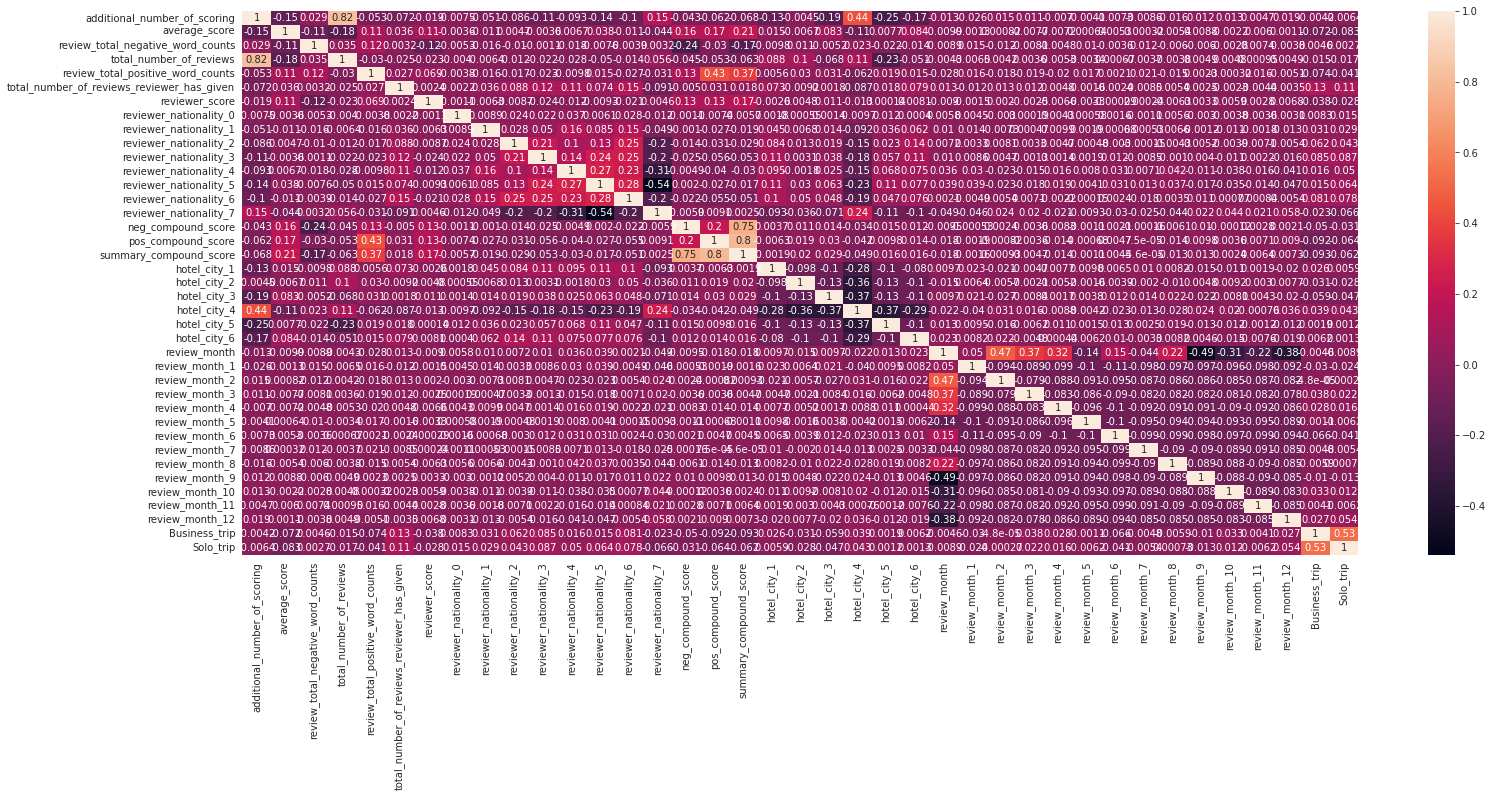

In [51]:
plt.rcParams['figure.figsize'] = (25,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

Не будем ничего удалять (в прошлых версиях дроп признаков больше 0.7 ухудшал общий результат)

In [52]:
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [53]:
#дропаем дату,(,'total_number_of_reviews','neg_compound_score','pos_compound_score' - в прошлой версии также
#дропали)
data.drop(['review_date','review_month'], axis= 1 , inplace= True )

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 39 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   sample                                      515738 non-null  int64  
 7   reviewer_score                              515738 non-null  float64
 8   reviewer_nationality_0                      515738 non-null  int64  
 9   reviewer_nationality_1                      515738 non-null  int64  
 

# 3. Обучение модели и получение предсказания

In [55]:
# Выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [56]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [57]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 38), (386803, 38), (386803, 37), (309442, 37), (77361, 37))

In [58]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [59]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [60]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.5s finished


In [61]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.8702189910711332


In [62]:
def mean_absolute_percentage_error(y_tr, y_pr):
    """Получение средней абсолютной ошибки"""
    y_tr, y_pr = np.array(y_tr), np.array(y_pr)
    return np.mean(np.abs((y_tr - y_pr) / y_tr)) * 100

print('MAPE:', round(mean_absolute_percentage_error(y_test, y_pred), 2))

MAPE: 12.37


<AxesSubplot:>

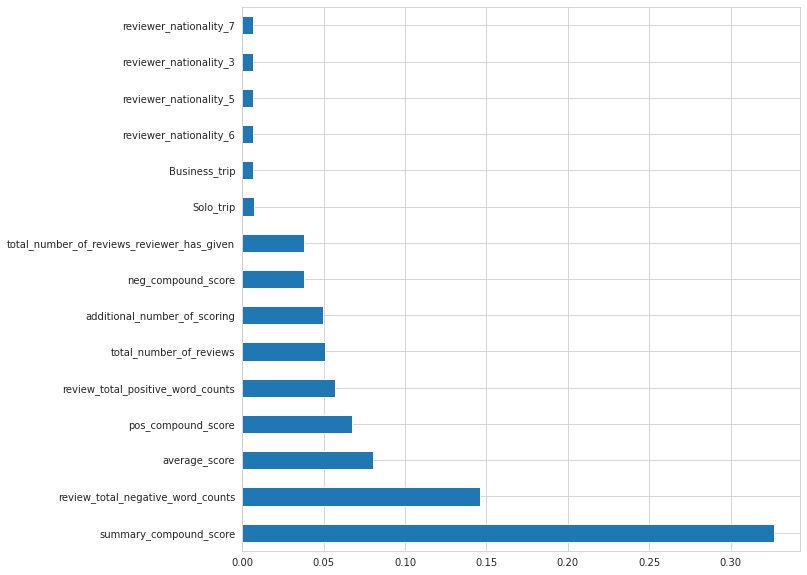

In [63]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [64]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,...,review_month_5,review_month_6,review_month_7,review_month_8,review_month_9,review_month_10,review_month_11,review_month_12,Business_trip,Solo_trip
55211,247,9.2,0,1914,8,5,0.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
111716,1058,7.7,35,4380,15,4,0.0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
86690,1172,7.8,2,5945,3,1,0.0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
48003,77,9.0,0,817,12,1,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44946,132,8.3,49,1174,16,3,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52847,724,8.0,4,3150,8,6,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36137,973,8.0,26,4820,8,4,0.0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
123793,2682,7.1,9,9086,3,4,0.0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
125719,341,8.2,10,1496,4,2,0.0,0,1,0,...,0,0,0,0,1,0,0,0,1,1
16008,660,8.4,7,2902,21,8,0.0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [65]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [66]:
sample_submission['reviewer_score']

0          1
1         10
2          3
3         10
4          9
          ..
128930     7
128931     1
128932     3
128933     6
128934     5
Name: reviewer_score, Length: 128935, dtype: int64

In [67]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.3s finished


In [68]:
predict_submission

array([8.767, 7.481, 7.941, ..., 8.423, 9.559, 7.449])

In [69]:
list(sample_submission)

['reviewer_score', 'id']

In [70]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.767,488440
1,7.481,274649
2,7.941,374688
3,9.752,404352
4,9.678,451596
5,8.865,302161
6,8.101,317079
7,7.629,13963
8,8.508,159785
9,7.813,195089


# 4. Выводы

Целевой показатель в 13.5% достигнут(согласно вебинару от ментора :) ), хотя можно было эксперементировать дальше. Основной упор на мой взгляд необходимо было делать на симантический разбор отзывов и местоположении отелей, возможно чуть позже вернусь к этой задачи, чтобы продолжить эксперименты. 
P.S. Хотя, кого я обманываю, тут каждый следующий проект интересней предыдушего :)